In [6]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle
%matplotlib inline



In [7]:
crashes = pd.read_csv('data/gp_grid_parkslope.csv')

n = len(crashes)
crashes.drop(crashes.columns[0], inplace = True, axis = 1)
crashes.sort_values(['DATE_IND', 'GRID_SQUARE'], inplace = True)
crashes['x_point'] = (crashes['x_point'] - 900000) / 10000 #+ np.random.normal(0,.001, size= n)
crashes['y_point'] = (crashes['y_point'] - 100000) / 10000 #+ np.random.normal(0,.001, size = n)




crashes['GRID_SQUARE'] = crashes['GRID_SQUARE'].astype(np.float32)
crashes['DATE_IND'] = crashes['DATE_IND'].astype(np.float32)

crashes.head()

,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND
0,2013-05-31,1.0,0.0,8.556851,8.800599,1.0
59,2013-05-31,2.0,0.0,8.556851,8.675599,1.0
118,2013-05-31,3.0,0.0,8.556851,8.550599,1.0
177,2013-05-31,4.0,1.0,8.556851,8.425599,1.0
236,2013-05-31,5.0,1.0,8.556851,8.300599,1.0


In [9]:
## source https://www.health.ny.gov/statistics/prevention/injury_prevention/traffic/county_of_residence.htm

per_100k = 696.6 / 12 # for months
per_cap  = per_100k / 100000
e_s = (39.270244500000004 / crashes.GRID_SQUARE.max()) # equally distribute pop among grid cells

#e_s = pop[pop['NTA Name'] == 'Park Slope-Gowanus'].Population.values[0] * per_cap

crashes['e_s'] = e_s

crashes.set_index('DATETIME', inplace = True)
#historical.groupby('BOROUGH')['NUMBER OF PEDESTRIANS INJURED'].sum()


In [10]:
dat = crashes.loc['2015-03-31':'2017-03-31'].copy()


X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point.ravel(), dat.y_point]).T
y = dat.COUNT.values.reshape((len(dat),1))


In [11]:
use_priors = True

with gpflow.defer_build():

    like = gpflow.likelihoods.Poisson(binsize = e_s)
    kern_s_effect = gpflow.kernels.Matern32(input_dim =  2, active_dims=[1,2], name='space_effect')
    kern_t_effect = gpflow.kernels.RBF(1, active_dims=[0], name='time_effect')

    ## Will have to write custom kernel to match Flaxman 2014
    kern_p_effect = gpflow.kernels.Periodic(1, active_dims=[0], name = 'periodic_effect')
    kern_st_effect = gpflow.kernels.Product([kern_s_effect ,kern_t_effect])

    full_kern =  kern_t_effect + kern_s_effect + kern_p_effect #+ kern_st_effect
    
    mean = gpflow.mean_functions.Identity(input_dim = 3)
    
    m = gpflow.models.VGP(X, y, full_kern,  likelihood = like, mean_function = None)
    
    m.kern.periodic.period = 12
    m.kern.periodic.period.trainable = True
    
    normal_prior = gpflow.priors.Gaussian(mu = 0 , var = 1)
    if use_priors:
        m.kern.rbf.variance.prior    = normal_prior
        m.kern.periodic.variance.prior = normal_prior
        m.kern.matern32.variance.prior    = gpflow.priors.Gaussian(mu = 0 , var = 5)
        
        m.kern.rbf.lengthscales.prior = normal_prior
        m.kern.periodic.lengthscales.prior = normal_prior
        m.kern.matern32.lengthscales.prior = normal_prior


m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/periodic/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,12.0
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/matern32/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/matern32/variance,Parameter,"N([ 0.],[ 5.])",+ve,True,(),True,1.0
VGP/q_mu,Parameter,None,(none),True,"(1200, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1200, 1200)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [12]:
m.compile()
opt = gpflow.train.ScipyOptimizer()

In [13]:
m.compute_log_likelihood()

-7744.5327442080097

In [14]:
opt.minimize(m, maxiter= 1500)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1667.293796
  Number of iterations: 550
  Number of functions evaluations: 573


In [15]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/periodic/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.1102167773087268
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.789998069966203
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,11.803349971960484
VGP/kern/rbf/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.001895302950645
VGP/kern/rbf/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.579644200637463
VGP/kern/matern32/lengthscales,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.22417627214900251
VGP/kern/matern32/variance,Parameter,"N([ 0.],[ 5.])",+ve,True,(),True,4.779191423593026
VGP/q_mu,Parameter,None,(none),True,"(1200, 1)",True,"[[-2.03342402335], [-0.414684311244], [0.57323..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1200, 1200)",True,"[[[-0.504139301228, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


In [16]:
dat = crashes

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point, dat.y_point]).T
y = dat.COUNT.values.reshape((len(dat),1))

pred_mean, pred_variance = m.predict_y(X)

dat['pred'] = pred_mean
dat['log_pred'] = np.log(pred_mean)


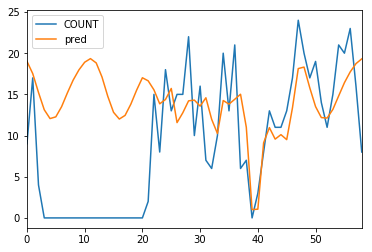

In [17]:
dat[dat.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()

In [21]:
predicted = crashes.loc['2017-04-30':'2018-02-28'].copy() # excluding last month because it is partial 
(np.square(predicted.pred - predicted.COUNT).sum()) * (1 / len(predicted))

3.9925394862198016

In [22]:
predicted['error'] = (predicted.pred - predicted.COUNT)
predicted['sq_error'] = np.square(predicted['error'])

forecast = predicted.groupby('DATETIME')
forecasting_error = forecast['sq_error'].sum() * (1 / forecast['GRID_SQUARE'].count())

forecasting_error



DATETIME
2017-04-30    7.390477
2017-05-31    4.899291
2017-06-30    2.644487
2017-07-31    3.556623
2017-08-31    2.104281
2017-09-30    2.126423
2017-10-31    1.872632
2017-11-30    3.930420
2017-12-31    4.690224
2018-01-31    4.928710
2018-02-28    5.774368
dtype: float64

In [23]:
aggregate_forecast = predicted.groupby('DATETIME')[['pred','COUNT']].sum()
aggregate_forecast['sq_error'] = np.square(aggregate_forecast.pred - aggregate_forecast.COUNT)

np.sqrt(aggregate_forecast.sq_error * (1 / len(aggregate_forecast)))

DATETIME
2017-04-30    13.553064
2017-05-31     7.440606
2017-06-30     4.519861
2017-07-31     2.013777
2017-08-31     7.292690
2017-09-30     4.419672
2017-10-31     4.082528
2017-11-30     8.088334
2017-12-31     7.815205
2018-01-31     7.591302
2018-02-28    20.985505
Name: sq_error, dtype: float64

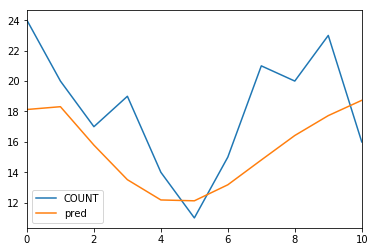

In [24]:
predicted[predicted.GRID_SQUARE == 33 ].reset_index()[['COUNT', 'pred']].plot()

In [25]:
#
params = m.read_trainables()
#pickle.dump( params, open( "matern_model.p", "wb" ) )
